In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

!python -m spacy download el_core_news_sm
import spacy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import re
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
nlp = spacy.load('el_core_news_sm')
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 61.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
/kaggle/input/greek-custom-stopwords/custom_greek_stopwords.csv
/kaggle/input/ys19-2023-assignment-1/sample_submission.csv
/kaggle/input/ys19-2023-assignment-1/test_set.csv
/kaggle/input/ys19-2023-assignment-1/valid_set.csv
/kaggle/input/ys19-2023-assignment-1/train_set.csv


In [2]:
train_data = pd.read_csv('../input/ys19-2023-assignment-1/train_set.csv')
valid_data = pd.read_csv('../input/ys19-2023-assignment-1/valid_set.csv')
test_data = pd.read_csv('../input/ys19-2023-assignment-1/test_set.csv')

In [3]:
def remove_hashtags_urls_mentions(text):
    text = re.sub(r'#', '', text)
    text = re.sub(r'https\S*','', text)
    text = re.sub(r'@\w+', '', text)
    return text

def remove_punctuations(text):
    text = re.sub(r'[.,!?:;/()|&]+', '', text)
    return text

def remove_special_characters(text):
    text = re.sub(r'[\"«»-]', '', text)
    return text


def process_tweets(data):
    custom_greek_stopwords = pd.read_csv('../input/greek-custom-stopwords/custom_greek_stopwords.csv', delimiter='\t')
    greek_stopwords = custom_greek_stopwords['greek_stopwords'].values.flatten().tolist()
    preprocessed_data = []
    
    for text in data['Text']:
        text = text.lower()
        text = remove_hashtags_urls_mentions(text)
        text = remove_punctuations(text)
        text = remove_special_characters(text)
        tweet_tokens = nlp(text)
            
        lem_tweets = []
        for word in tweet_tokens:
            lem_word = word.lemma_
            if (lem_word not in greek_stopwords):
                lem_tweets.append(lem_word)
        preprocessed_data.append(' '.join(lem_tweets))
        
    return preprocessed_data
    


In [4]:
import time

start_time = time.time()
preprocessed_train_data_text = process_tweets(train_data)
preprocessed_test_data_text = process_tweets(test_data)
preprocessed_valid_data_text = process_tweets(valid_data)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 422.3880 seconds


In [5]:
label_encoder = LabelEncoder()
train_sentiments = label_encoder.fit_transform(train_data['Sentiment'])
valid_sentiments = label_encoder.fit_transform(valid_data['Sentiment'])
# # Negative = 0, Neutral = 1, Positive = 2

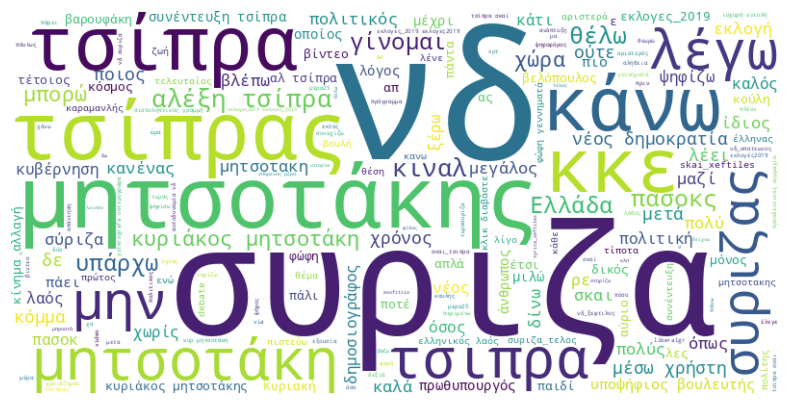

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(preprocessed_train_data_text)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
from collections import Counter

tokens = " ".join(preprocessed_train_data_text).split()

word_freq = Counter(tokens)

top_n = 20
print(f"Top {top_n} most frequent words:")
for word, freq in word_freq.most_common(top_n):
    print(f"{word}: {freq} occurences")

Top 20 most frequent words:
νδ: 6564 occurences
τσίπρα: 5144 occurences
μητσοτάκη: 3824 occurences
μητσοτάκης: 3716 occurences
συριζα: 3619 occurences
κκε: 2903 occurences
τσίπρας: 2580 occurences
κάνω: 2242 occurences
τσιπρα: 2060 occurences
νέος: 2044 occurences
κιναλ: 1898 occurences
εκλογή: 1801 occurences
μην: 1750 occurences
εκλογες_2019: 1742 occurences
συριζας: 1732 occurences
λέγω: 1475 occurences
σκαι: 1456 occurences
κυριάκος: 1418 occurences
πασοκς: 1334 occurences
θέλω: 1318 occurences


In [8]:
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(preprocessed_train_data_text)
y = train_sentiments
valid_X = vectorizer.transform(preprocessed_valid_data_text)
valid_y = valid_sentiments
test_X = vectorizer.transform(preprocessed_test_data_text)

In [9]:
# Finding the best params for Logistic Regression on training_data
# And train the model on train_test_split

from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_regression = LogisticRegression(max_iter=10000)

params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(logistic_regression, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Best Hyperparameters: {'C': 0.1, 'solver': 'lbfgs'}
Accuracy: 0.3808353808353808
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.44      0.40      2447
           1       0.38      0.33      0.35      2450
           2       0.39      0.37      0.38      2429

    accuracy                           0.38      7326
   macro avg       0.38      0.38      0.38      7326
weighted avg       0.38      0.38      0.38      7326



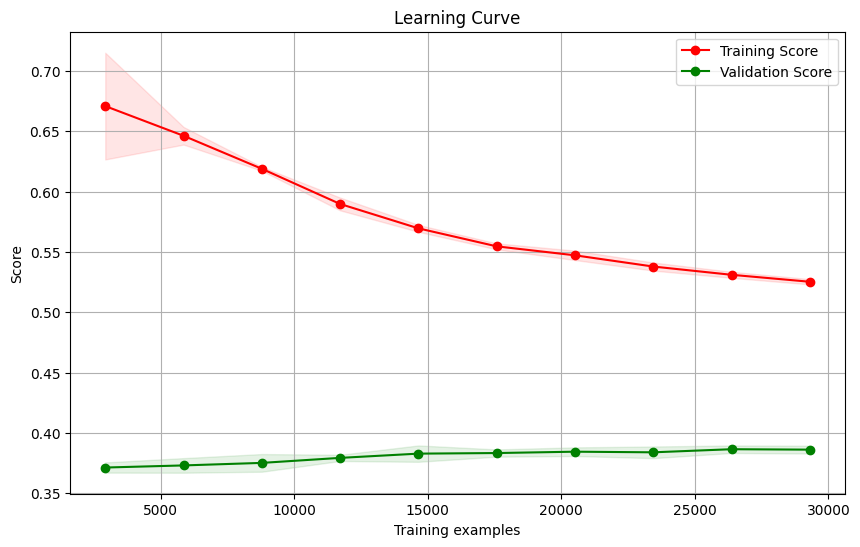

In [10]:
# Learning Curve on Logistic Regression

model = LogisticRegression(max_iter=1000, C=grid_search.best_params_['C'], 
                           solver=grid_search.best_params_['solver'])

train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_std = np.std(train_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Score')

# Filling determines the uncertainty
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

In [11]:
# Simple train/test on training data

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, C=grid_search.best_params_['C'], 
                           solver=grid_search.best_params_['solver'])
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.3808353808353808
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.44      0.40      2447
           1       0.38      0.33      0.35      2450
           2       0.39      0.37      0.38      2429

    accuracy                           0.38      7326
   macro avg       0.38      0.38      0.38      7326
weighted avg       0.38      0.38      0.38      7326



In [12]:
#Simple train/test on training data with dimension reduction

from sklearn.decomposition import TruncatedSVD

n_components = 100
svd = TruncatedSVD(n_components=n_components)

X_svd = svd.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_svd, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, C=grid_search.best_params_['C'], 
                           solver=grid_search.best_params_['solver'])
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.37223587223587223
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.47      0.41      2447
           1       0.37      0.29      0.32      2450
           2       0.38      0.36      0.37      2429

    accuracy                           0.37      7326
   macro avg       0.37      0.37      0.37      7326
weighted avg       0.37      0.37      0.37      7326



In [13]:
# KFold cross-validation train, Mean Classification Report and Mean Accuracy

kf = KFold(n_splits=10, shuffle=True, random_state=42)

model = LogisticRegression(max_iter=1000, C=grid_search.best_params_['C'], 
                           solver=grid_search.best_params_['solver'])
all_reports = []
cv_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
   
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    all_reports.append(report)
    cv_scores.append(accuracy)

    # print(f"Fold {fold} - Accuracy: {accuracy:.2f}")
    # print(f"Fold {fold} - Classification Report:\n{report}\n")
    
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
mean_report = {
    'precision': np.mean([report['weighted avg']['precision'] for report in all_reports]),
    'recall': np.mean([report['weighted avg']['recall'] for report in all_reports]),
    'f1-score': np.mean([report['weighted avg']['f1-score'] for report in all_reports]),
    'support': np.mean([report['weighted avg']['support'] for report in all_reports]),
}

print("Mean Classification Report:")
print(classification_report(y_val, y_pred, output_dict=False))
print(f"Cross-Validation Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")

Mean Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.44      0.41      1238
           1       0.40      0.35      0.37      1217
           2       0.39      0.38      0.39      1208

    accuracy                           0.39      3663
   macro avg       0.39      0.39      0.39      3663
weighted avg       0.39      0.39      0.39      3663

Cross-Validation Accuracy: 0.39 ± 0.00


In [14]:
from sklearn.decomposition import TruncatedSVD

kf = KFold(n_splits=10, shuffle=True, random_state=42)
model = LogisticRegression(max_iter=1000, C=grid_search.best_params_['C'], 
                           solver=grid_search.best_params_['solver'])
all_reports = []
cv_scores = []

n_components = 100
svd = TruncatedSVD(n_components=n_components)

for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Transform data using TruncatedSVD
    X_train_svd = svd.fit_transform(X_train)
    X_val_svd = svd.transform(X_val)

    model.fit(X_train_svd, y_train)

    y_pred = model.predict(X_val_svd)

    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    all_reports.append(report)
    cv_scores.append(accuracy)

mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
mean_report = {
    'precision': np.mean([report['weighted avg']['precision'] for report in all_reports]),
    'recall': np.mean([report['weighted avg']['recall'] for report in all_reports]),
    'f1-score': np.mean([report['weighted avg']['f1-score'] for report in all_reports]),
    'support': np.mean([report['weighted avg']['support'] for report in all_reports]),
}

print("Mean Classification Report:")
print(classification_report(y_val, y_pred))
print(f"Cross-Validation Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")


Mean Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.49      0.43      1238
           1       0.40      0.30      0.34      1217
           2       0.38      0.36      0.37      1208

    accuracy                           0.38      3663
   macro avg       0.39      0.38      0.38      3663
weighted avg       0.39      0.38      0.38      3663

Cross-Validation Accuracy: 0.38 ± 0.01


Text(0.5, 1.0, 'Confusion Matrix - Validation Data')

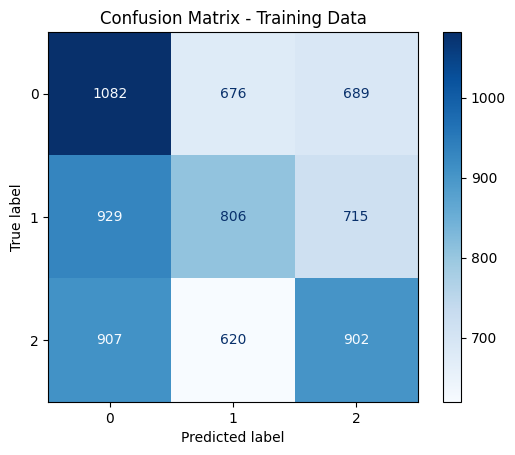

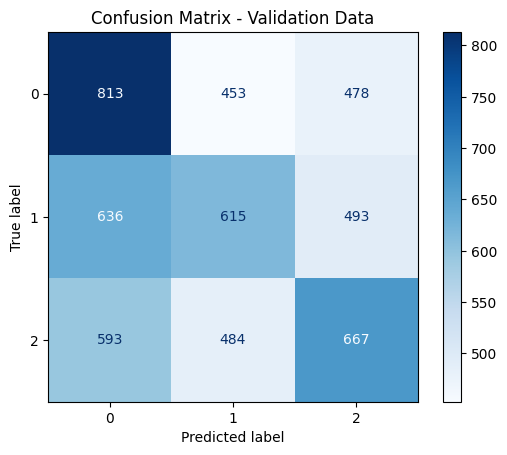

In [15]:
# Confusion matrices for train and valid data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
# using different model than the one on KFold   
model = LogisticRegression(max_iter=1000, C=grid_search.best_params_['C'], 
                           solver=grid_search.best_params_['solver'])

model.fit(X_train, y_train)
train_predictions = model.predict(X_val)

train_matrix = confusion_matrix(y_val, train_predictions, labels=model.classes_)

train_plot = ConfusionMatrixDisplay(confusion_matrix=train_matrix, display_labels=model.classes_)
train_plot.plot(cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.title('Confusion Matrix - Training Data')

predicted_valid_sentiments = model.predict(valid_X)

val_matrix = confusion_matrix(valid_y, predicted_valid_sentiments, labels=model.classes_)

val_plot = ConfusionMatrixDisplay(confusion_matrix=val_matrix, display_labels=model.classes_)
val_plot.plot(cmap='Blues', values_format='d', xticks_rotation='horizontal')
plt.title('Confusion Matrix - Validation Data')

In [16]:
# Predicting and validating model on validatio_dataset

predicted_valid_sentiments = model.predict(valid_X)

valid_sentiments = label_encoder.transform(valid_data['Sentiment'])
valid_accuracy = accuracy_score(valid_sentiments, predicted_valid_sentiments)
valid_report = classification_report(valid_sentiments, predicted_valid_sentiments)

print("Validation Accuracy:", valid_accuracy)
print("Classification Report:\n", valid_report)

Validation Accuracy: 0.4004204892966361
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.47      0.43      1744
           1       0.40      0.35      0.37      1744
           2       0.41      0.38      0.39      1744

    accuracy                           0.40      5232
   macro avg       0.40      0.40      0.40      5232
weighted avg       0.40      0.40      0.40      5232



In [17]:
predicted_sentiments = model.predict(test_X)
predicted_sentiment_labels = label_encoder.inverse_transform(predicted_sentiments)

predictions_df = pd.DataFrame({
    'Id': range(1, len(test_data) + 1),
    'Predicted': predicted_sentiment_labels})
predictions_df.to_csv('submission.csv', index=False)